In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.optimize import lsq_linear
from sklearn.linear_model import LinearRegression
import pickle
import h5py as h5
import mplhep as hep
hep.style.use("CMS")

## Configuration

### Plotting styling

In [3]:
colors = {}
colors['Threshold0'] = 'black'
colors['Threshold'] = 'black'
colors['Mixedbcstc'] = 'black'
colors['AutoEncoderTelescopeMSE'] = 'tab:blue'
colors['AutoEncoderStride'] = 'tab:orange'
colors['AutoEncoderQKerasTTbar'] = 'tab:red'
colors['AutoEncoderQKerasEle'] = 'tab:green'


styles = {}
styles['Threshold0'] = '-'
styles['Threshold'] = '-.'
styles['Mixedbcstc'] = '--'
styles['AutoEncoderTelescopeMSE'] = '-'
styles['AutoEncoderStride'] = '-'
styles['AutoEncoderQKerasTTbar'] = '--'
styles['AutoEncoderQKerasEle'] = '--'

markers = {}
markers['Threshold0'] = 'o'
markers['Threshold'] = 'o'
markers['Mixedbcstc'] = 'o'
markers['AutoEncoderTelescopeMSE'] = 'o'
markers['AutoEncoderStride'] = 'o'
markers['AutoEncoderQKerasTTbar'] = 'o'
markers['AutoEncoderQKerasEle'] = 'o'



legends = {}
legends['Threshold0'] = 'All TC'
legends['Threshold'] = 'Threshold 1.35 mipT'
legends['Mixedbcstc'] = 'BC+STC'
legends['AutoEncoderTelescopeMSE'] = 'AE Telescope MSE'
legends['AutoEncoderStride'] = 'AE Stride'
legends['AutoEncoderQKerasTTbar'] = 'AE QKeras ttbar'
legends['AutoEncoderQKerasEle'] = 'AE QKeras Ele'

ref_name = 'Threshold0'
plotted_algo = ['Threshold0',
                'Threshold',
                'Mixedbcstc',
                'AutoEncoderTelescopeMSE', 
                'AutoEncoderStride',
                'AutoEncoderQKerasTTbar',
                'AutoEncoderQKerasEle',
               ]

### Input files and FE algorithms to be studied
Both 200PU electron gun and 0PU photon guns are loaded

In [4]:
version = '210430'
fig_dir = '../img/'.format(version)
algo_files = {}
# Read  first set
directory = '/home/llr/cms/sarkar/HDF5'

fes = ['ak4jet', 'ak4jet_matched', 'dR_jet_matched', 'dR_matched_gen', 'gen_clean', 'genjet_clean', 'gen_matched', 
      'genjet_matched','genjet_matched_ak4jets','mindR_jet_matched','mindR_matched_gen',]

for fe in fes:
    algo_files[fe] = (glob(directory+'/*.hdf5'))

#    print(algo_files[fe])

## Loading and preprocessing dataframes

In [5]:
algos_dfs = {}
for fe,files in algo_files.items():
    name = fe
    dfs = []
    for file in files:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    algos_dfs[fe] = pd.concat(dfs)
algo_names = sorted(algos_dfs.keys())

print(algos_dfs)

{'ak4jet':                        pt       eta       phi
entry subentry                               
0     0         16.178299  2.574984  1.436344
      1         14.084973  2.662509 -0.002585
      2         13.675381  2.681460 -0.805456
      3          9.700790  2.716631 -2.166124
      4          8.619481  2.475327  0.584310
...                   ...       ...       ...
611   4         22.275666  2.765522 -2.368786
      5         20.022651 -2.796691  1.329787
      6         10.681826 -2.690022 -2.333144
      7          7.374722  2.240159 -1.096622
      8          5.924691 -2.635834 -0.827727

[701395 rows x 3 columns], 'ak4jet_matched':                         pt       eta       phi
entry subentry                                
1     0          42.710254 -2.593301 -3.136473
13    0          55.432400 -2.169074  1.243633
      1          39.863588  2.497408  2.922446
14    0          70.690800 -2.208110  2.755778
15    0          71.402947  2.666551  0.953971
...             

In [6]:
#print('number of gen')
#for i in range(len(algos_dfs['gen_clean'])):
#    print(len(algos_dfs['gen_clean']['pt'][i]))

#print('number of genjet')
#print(len(algos_dfs['genjet_clean']))
#print('number of gen matched to genjet')
#print(len(algos_dfs['gen_matched']))
#print('number of genjet matched to gen')
#print(len(algos_dfs['genjet_matched']))
#print('number of ak4jet')
#print(len(algos_dfs['ak4jet']))
#print('number of ak4jet matched to selected genjets')
#print(len(algos_dfs['ak4jet_matched']))
#print('number of genjets matched to ak4jets')
#print(len(algos_dfs['genjet_matched_ak4jets']))


In [7]:
#for i in range(len(algos_dfs['genjet_matched'])):
#    print(len(algos_dfs['genjet_matched']['pt'][i]))

In [8]:
algos_dfs['pt_ratio_gen_genjet'] = algos_dfs['genjet_matched']['pt']/algos_dfs['gen_clean']['pt']
algos_dfs['pt_ratio_genmatched_genjet'] = algos_dfs['genjet_matched']['pt']/algos_dfs['gen_matched']['pt']

In [9]:
algos_dfs['genjet_matched_pt']= algos_dfs['genjet_matched']['pt'].reset_index(drop=True)

In [10]:
algos_dfs['gen_clean_pt'] = algos_dfs['gen_clean']['pt'].reset_index(drop=True)

In [11]:
algos_dfs['ratio'] = algos_dfs['genjet_matched_pt']/algos_dfs['gen_clean_pt']
#print(algos_dfs['ratio'])

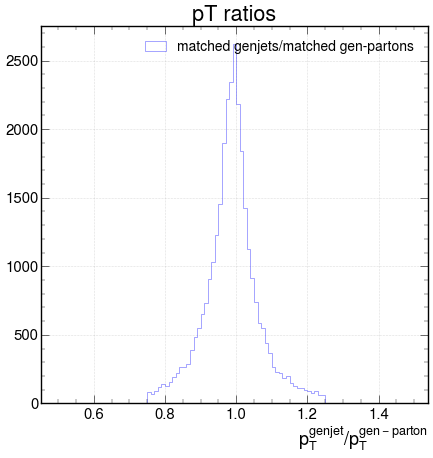

In [12]:
plt.figure(dpi=50)
#plt.hist(algos_dfs['ratio'], bins=np.arange(0.0, 4.0, 0.01), alpha=0.5, label='matched genjets/gen-partons')
plt.hist(algos_dfs['pt_ratio_genmatched_genjet'], histtype='step', color='blue',bins=np.arange(0.5, 1.5, 0.01), alpha=0.5, label='matched genjets/matched gen-partons')
plt.title('pT ratios')
plt.legend(fontsize=20)
plt.xlabel(r'$p_{T}^{genjet}/p_{T}^{gen-parton}$')
plt.grid()
#plt.yscale('log')
plt.show()

In [13]:
algos_dfs['genjet_num'] = algos_dfs['genjet_matched']['pt']/algos_dfs['genjet_matched']['pt']
algos_dfs['gen_num'] = algos_dfs['gen_clean']['pt']/algos_dfs['gen_clean']['pt']
algos_dfs['ratio_num'] = algos_dfs['genjet_num']/algos_dfs['gen_num']

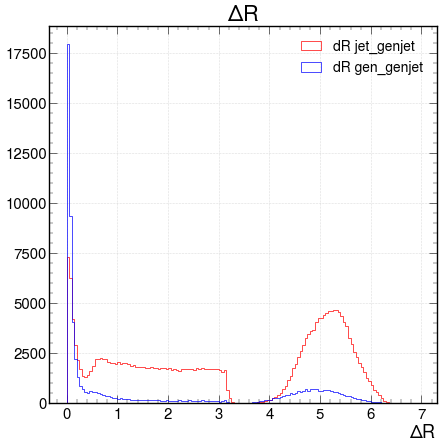

In [33]:
plt.figure(dpi=50)
plt.hist(algos_dfs['dR_jet_matched'],histtype='step',bins=np.arange(0.0, 7., 0.05), color='red',  label='dR jet_genjet')
plt.hist(algos_dfs['dR_matched_gen'],histtype='step',bins=np.arange(0., 7., 0.05), color='blue', label='dR gen_genjet')
plt.title('$\Delta$R')
plt.legend(fontsize=20)
plt.xlabel('$\Delta$R')
plt.grid()
plt.show()

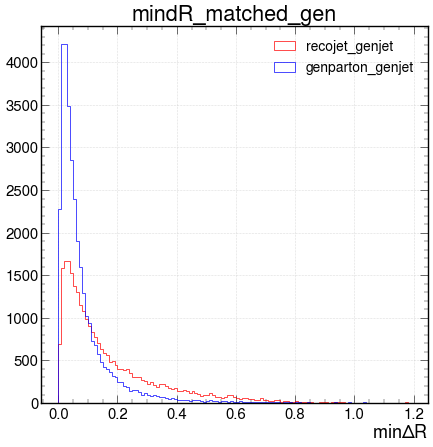

In [34]:
plt.figure(dpi=50)
plt.hist(algos_dfs['mindR_jet_matched'],histtype='step',bins=np.arange(0., 1.2, 0.01), color='red', label='recojet_genjet')
plt.hist(algos_dfs['mindR_matched_gen'],histtype='step',bins=np.arange(0., 1.2, 0.01),  color='blue', label='genparton_genjet')
plt.title(name)
plt.legend(fontsize=20)
plt.xlabel('min$\Delta$R')
plt.grid()
plt.show()

In [16]:
algos_dfs['ak4jet_matched_pt']= algos_dfs['ak4jet_matched']['pt'].reset_index(drop=True)
algos_dfs['genjet_matched_ak4jets_pt'] = algos_dfs['genjet_matched_ak4jets']['pt'].reset_index(drop=True)
algos_dfs['pt_ratio_ak4jet_genjet'] = algos_dfs['ak4jet_matched_pt']/algos_dfs['genjet_matched_pt']
algos_dfs['pt_ratio_ak4jetmatched_genjet'] = algos_dfs['ak4jet_matched_pt']/algos_dfs['genjet_matched_ak4jets_pt']

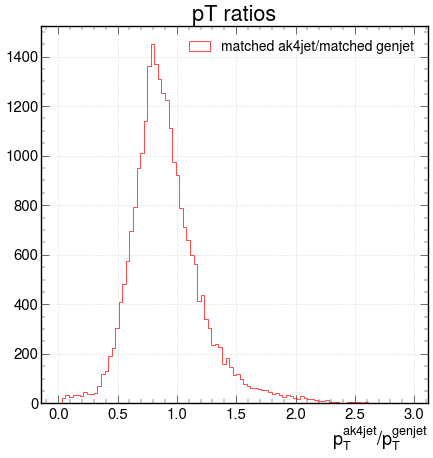

In [35]:
plt.figure(dpi=50)
#plt.hist(algos_dfs['pt_ratio_ak4jet_genjet'], bins=np.arange(0.0, 6.0, 0.01), alpha=0.5, label='matched ak4jet/genjet')
plt.hist(algos_dfs['pt_ratio_ak4jetmatched_genjet'],histtype='step', bins=np.arange(0.0, 3.0, 0.03), color='red', label='matched ak4jet/matched genjet')
plt.title('pT ratios')
plt.legend(fontsize=20)
plt.xlabel(r'$p_{T}^{ak4jet}/p_{T}^{genjet}$')
plt.grid()
plt.show()

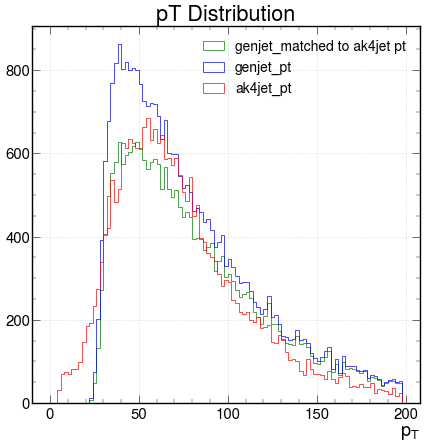

In [36]:
plt.figure(dpi=50)
plt.hist(algos_dfs['genjet_matched_ak4jets']['pt'],histtype='step', bins=np.arange(0.0, 200.0, 2.0), color='g',label='genjet_matched to ak4jet pt')
plt.hist(algos_dfs['genjet_matched']['pt'],histtype='step', bins=np.arange(0.0, 200.0, 2.0),color='blue',  label='genjet_pt')
plt.hist(algos_dfs['ak4jet_matched']['pt'],histtype='step',bins=np.arange(0.0, 200.0, 2.0), color='red', label='ak4jet_pt')
plt.title('pT Distribution')
plt.legend(fontsize=20)
plt.xlabel(r'$p_{T}$')
plt.grid()
plt.show()

In [19]:
layer_coeffs = {}
layers = np.array(algos_dfs['ak4jet_matched']['pt'].tolist())
print(layers.shape)
layers=layers.reshape(len(layers),1)
print(layers.shape)
layers2 = np.array(algos_dfs['genjet_matched_ak4jets']['pt'].tolist())
#layers2=layers2.reshape(len(layers2),1)
layers3 = np.concatenate((layers,layers),axis=1)

print(layers3.shape,len(layers2))
regression = lsq_linear(layers, layers2,
                              method='bvls')
layer_coeffs = regression.x
print(regression.x)

(25666,)
(25666, 1)
(25666, 2) 25666
[1.15214721]


In [20]:
# Apply calibration
layers = np.array(algos_dfs['ak4jet_matched']['pt'].tolist())
layers=layers.reshape(len(layers),1)
algos_dfs['ak4jetmatched_pt_calib'] = np.dot(layers, layer_coeffs)
#algos_dfs['ak4jet_over_genjet_pt'] = algos_dfs['pt_ratio_ak4jet_genjet']
algos_dfs['ak4jet_over_genjet_pt'] = algos_dfs['ak4jet_matched']['pt']/algos_dfs['genjet_matched_ak4jets']['pt']
algos_dfs['calib_over_genjet_pt'] = algos_dfs['ak4jetmatched_pt_calib']/algos_dfs['genjet_matched_ak4jets']['pt']

ak4jet_over_genjet_pt = algos_dfs['ak4jet_over_genjet_pt'].tolist()
#print(ak4jet_over_genjet_pt)

Raw mean=0.911167600288194, rms=0.310962291884141, rms/mean=0.3412789170573959
Calib mean=1.0497992072243651, rms=0.35827433656925006, rms/mean=0.3412789170574016


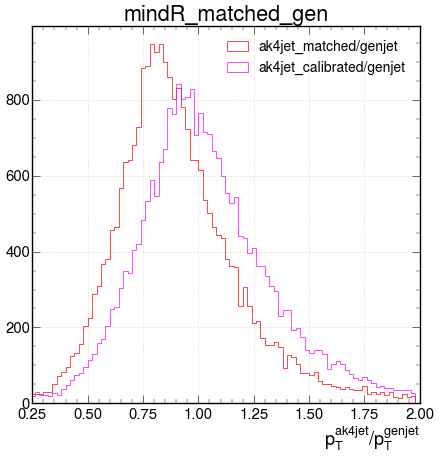

In [37]:
print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        algos_dfs['ak4jet_over_genjet_pt'].mean(),
        algos_dfs['ak4jet_over_genjet_pt'].std(),
        algos_dfs['ak4jet_over_genjet_pt'].std()/algos_dfs['ak4jet_over_genjet_pt'].mean()
    ))
print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        algos_dfs['calib_over_genjet_pt'].mean(),
        algos_dfs['calib_over_genjet_pt'].std(),
        algos_dfs['calib_over_genjet_pt'].std()/algos_dfs['calib_over_genjet_pt'].mean()
    ))
    
plt.figure(dpi=50)
plt.hist(algos_dfs['ak4jet_over_genjet_pt'],histtype='step', bins=np.arange(0.0, 2.0, 0.02),color='red', label='ak4jet_matched/genjet')
plt.hist(algos_dfs['calib_over_genjet_pt'],histtype='step', bins=np.arange(0.0, 2.0, 0.02), color='magenta', label='ak4jet_calibrated/genjet')
plt.title(name)
plt.legend(fontsize=20)
plt.xlim([0.25, 2])
plt.xlabel(r'$p_{T}^{ak4jet}/p_{T}^{genjet}$')
plt.grid()
plt.show()

In [22]:
corrs = {}
corrs['eta'] = {}
    # select = df.query('genpart_pid==1')
#X = algos_dfs['ak4jet_matched']['eta']
#x = X.reshape(1,-1)

X = np.array(algos_dfs['ak4jet_matched']['eta'].tolist())
print(layers.shape)
x=X.reshape(len(X),1)

#y = algos_dfs['genjet_matched_ak4jets']['pt']-algos_dfs['ak4jetmatched_pt_calib']
y = algos_dfs['genjet_matched_ak4jets']['pt']-algos_dfs['ak4jet_matched']['pt']

corrs['eta'] = LinearRegression().fit(x, y)

(25666, 1)


In [23]:
corr = corrs['eta']
print('  eta=1.5:', corr.intercept_+corr.coef_*1.5)
print('  eta=3:', corr.intercept_+corr.coef_*3)

  eta=1.5: [12.57006187]
  eta=3: [12.36772854]


In [24]:
eta = np.array(algos_dfs['ak4jet_matched']['eta'].tolist())
eta = eta.reshape(len(eta),1)
algos_dfs['ak4jet_corr_eta'] = corrs['eta'].predict(eta)
algos_dfs['ak4jet_pt_corr_eta'] =  algos_dfs['ak4jet_corr_eta']+algos_dfs['ak4jetmatched_pt_calib']
algos_dfs['corr_eta_over_gen_pt'] = algos_dfs['ak4jet_pt_corr_eta']/algos_dfs['genjet_matched_ak4jets']['pt']    

Raw mean=0.911167600288194, rms=0.310962291884141, rms/mean=0.3412789170573959
Calib mean=1.0497992072243651, rms=0.35827433656925006, rms/mean=0.3412789170574016
Corr eta mean=1.101483745816776, rms=0.35841919904047254, rms/mean=0.3253967209245528


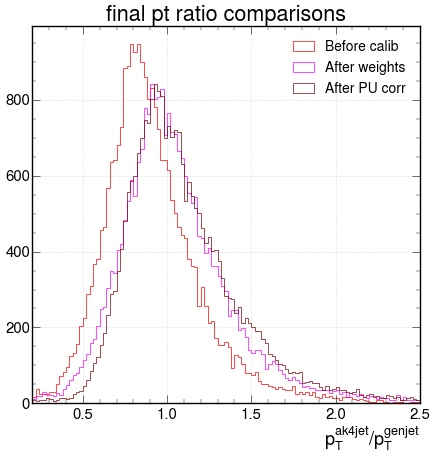

In [38]:
print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        algos_dfs['ak4jet_over_genjet_pt'].mean(),
        algos_dfs['ak4jet_over_genjet_pt'].std(),
        algos_dfs['ak4jet_over_genjet_pt'].std()/algos_dfs['ak4jet_over_genjet_pt'].mean()
    ))
print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        algos_dfs['calib_over_genjet_pt'].mean(),
        algos_dfs['calib_over_genjet_pt'].std(),
        algos_dfs['calib_over_genjet_pt'].std()/algos_dfs['calib_over_genjet_pt'].mean()
    ))
print('Corr eta mean={0}, rms={1}, rms/mean={2}'.format(
        algos_dfs['corr_eta_over_gen_pt'].mean(),
        algos_dfs['corr_eta_over_gen_pt'].std(),
        algos_dfs['corr_eta_over_gen_pt'].std()/algos_dfs['corr_eta_over_gen_pt'].mean()
    ))
#plt.figure(figsize=(15,10))
plt.figure(dpi=50)
plt.hist(algos_dfs['ak4jet_over_genjet_pt'],histtype='step', bins=np.arange(0., 4., 0.02),color='red',  label='Before calib')
plt.hist(algos_dfs['calib_over_genjet_pt'],histtype='step', bins=np.arange(0., 4., 0.02), color='magenta', label='After weights')
plt.hist(algos_dfs['corr_eta_over_gen_pt'],histtype='step', bins=np.arange(0., 4., 0.02), color='maroon', label='After PU corr')
plt.grid()
plt.legend(loc = 'upper right', fontsize=20)
#plt.yscale('log')
plt.xlim([0.2, 2.5])
plt.title('final pt ratio comparisons')
plt.xlabel(r'$p_{T}^{ak4jet}/p_{T}^{genjet}$')
plt.show()

Without doing the PT calibration, results from only eta dependent regression

In [26]:
eta = np.array(algos_dfs['ak4jet_matched']['eta'].tolist())
eta = eta.reshape(len(eta),1)
algos_dfs['ak4jet_corr_eta'] = corrs['eta'].predict(eta)
algos_dfs['ak4jet_pt_corr_eta'] =  algos_dfs['ak4jet_corr_eta']+algos_dfs['ak4jet_matched']['pt']
algos_dfs['corr_eta_over_gen_pt'] = algos_dfs['ak4jet_pt_corr_eta']/algos_dfs['genjet_matched_ak4jets']['pt']   

Raw mean=0.911167600288194, rms=0.310962291884141, rms/mean=0.3412789170573959
Calib mean=1.0497992072243651, rms=0.35827433656925006, rms/mean=0.3412789170574016
Corr eta mean=1.101483745816776, rms=0.35841919904047254, rms/mean=0.3253967209245528


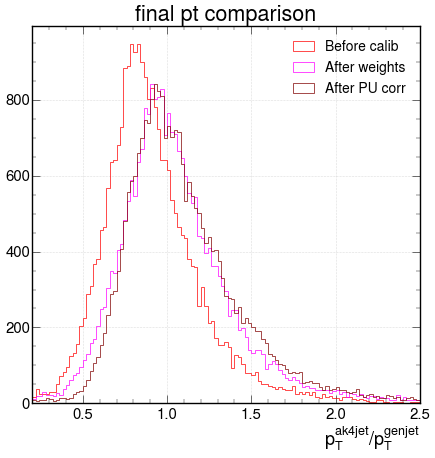

In [39]:
print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        algos_dfs['ak4jet_over_genjet_pt'].mean(),
        algos_dfs['ak4jet_over_genjet_pt'].std(),
        algos_dfs['ak4jet_over_genjet_pt'].std()/algos_dfs['ak4jet_over_genjet_pt'].mean()
    ))
print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        algos_dfs['calib_over_genjet_pt'].mean(),
        algos_dfs['calib_over_genjet_pt'].std(),
        algos_dfs['calib_over_genjet_pt'].std()/algos_dfs['calib_over_genjet_pt'].mean()
    ))
print('Corr eta mean={0}, rms={1}, rms/mean={2}'.format(
        algos_dfs['corr_eta_over_gen_pt'].mean(),
        algos_dfs['corr_eta_over_gen_pt'].std(),
        algos_dfs['corr_eta_over_gen_pt'].std()/algos_dfs['corr_eta_over_gen_pt'].mean()
    ))
#plt.figure(figsize=(15,10))
plt.figure(dpi=50)
plt.hist(algos_dfs['ak4jet_over_genjet_pt'],histtype='step', bins=np.arange(0., 4., 0.02), color='red', label='Before calib')
plt.hist(algos_dfs['calib_over_genjet_pt'],histtype='step', bins=np.arange(0., 4., 0.02), color='magenta', label='After weights')
plt.hist(algos_dfs['corr_eta_over_gen_pt'],histtype='step', bins=np.arange(0., 4., 0.02), color='maroon', label='After PU corr')
plt.grid()
plt.legend(loc = 'upper right', fontsize=20)
#plt.yscale('log')
plt.title('final pt comparison')
plt.xlim([0.2, 2.5])
plt.xlabel(r'$p_{T}^{ak4jet}/p_{T}^{genjet}$')
plt.show()

## Final plots

In [28]:
binetasize = 0.1
binptsize = 5
select_dfs = {}
select_dfs['genjet_abseta'] = np.abs(algos_dfs['genjet_matched_ak4jets']['eta'])
select_dfs['genjet_bineta'] = ((algos_dfs['genjet_matched_ak4jets']['eta'] - 1.6)/binetasize).astype('int32')
select_dfs['genjet_binpt'] = (algos_dfs['genjet_matched_ak4jets']['pt']/binptsize).astype('int32')

In [29]:
algos_dfs['genjet_matched_ak4jets_eta'] = algos_dfs['genjet_matched_ak4jets']['eta'].reset_index(drop=True)
algos_dfs['ak4jet_matched_eta'] = algos_dfs['ak4jet_matched']['eta'].reset_index(drop=True)
select_dfs['genjet_pt'] = (algos_dfs['genjet_matched_ak4jets']['pt'])
select_dfs['genjet_eta'] = (algos_dfs['genjet_matched_ak4jets_eta'])
select_dfs['ak4jet_pt'] = (algos_dfs['ak4jet_matched_pt'])
select_dfs['ak4jet_eta'] = (algos_dfs['ak4jet_matched_eta'])
select_dfs['ak4jet_pt_calib'] = algos_dfs['ak4jetmatched_pt_calib']
select_dfs['ak4jet_pt_corr_eta'] = algos_dfs['ak4jet_pt_corr_eta']
select_dfs['ak4jet_over_gen_pt'] = algos_dfs['ak4jet_over_genjet_pt']
select_dfs['calib_over_genjet_pt'] = algos_dfs['calib_over_genjet_pt']
select_dfs['corr_eta_over_gen_pt'] = algos_dfs['corr_eta_over_gen_pt']

Compute the mean, RMS, and effective RMS of the pT ratios in each eta and pT bin

In [30]:
def effrms(df, c=0.68):
    """Compute half-width of the shortest interval
    containing a fraction 'c' of items in a 1D array.
    """
    out = {}
    for col in df:
        x = df[col]
        x = np.sort(x, kind="mergesort")
        m = int(c * len(x)) + 1
        out[col] = [np.min(x[m:] - x[:-m]) / 2.0]
    return pd.DataFrame(out).iloc[0]

AttributeError: 'dict' object has no attribute 'query'

Mean vs eta


KeyError: 'mindR_matched_gen'

<Figure size 1080x720 with 0 Axes>